# xBD test 데이터셋 추론 (모델 로드)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from tensorflow.keras.preprocessing.image import load_img, array_to_img
import numpy as np
from tensorflow import keras
import math

# 추론용 데이터 제너레이터 클래스 정의
class xBDInference(keras.utils.Sequence):
    def __init__(self, batch_size, img_size, input_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths

    def __len__(self):
        return math.ceil(len(self.input_img_paths) / self.batch_size)

    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i: i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype='float32')
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        return x


In [5]:
from tensorflow.keras.models import load_model

# .h5 파일로부터 모델 로드
model = load_model('/content/xbd_segmentation_v1.h5')

In [ ]:
!tar -xvf '/content/drive/MyDrive/Colab_Notebooks/xBD/test_images_labels_targets.tar' -C '/content/'

In [6]:
import os

input_dir = 'test/images'
target_dir = 'test/targets'
img_size = (512, 512)
num_classes = 2
batch_size = 1

input_img_paths = sorted([ os.path.join(input_dir, fname)
                           for fname in os.listdir(input_dir)
                           if fname.endswith('pre_disaster.png')])

target_img_paths = sorted([ os.path.join(target_dir, fname)
                           for fname in os.listdir(target_dir)
                           if fname.endswith('pre_disaster_target.png')])

print(input_img_paths[7])

print(target_img_paths[7])

test_input_img_paths = input_img_paths
test_target_img_paths = target_img_paths

test/images/hurricane-florence_00000007_pre_disaster.png
test/targets/hurricane-florence_00000007_pre_disaster_target.png


In [7]:
test_gen = xBDInference(batch_size, img_size, test_input_img_paths)

test_preds = model.predict(test_gen)

933/933 [==============================] - 76s 76ms/step


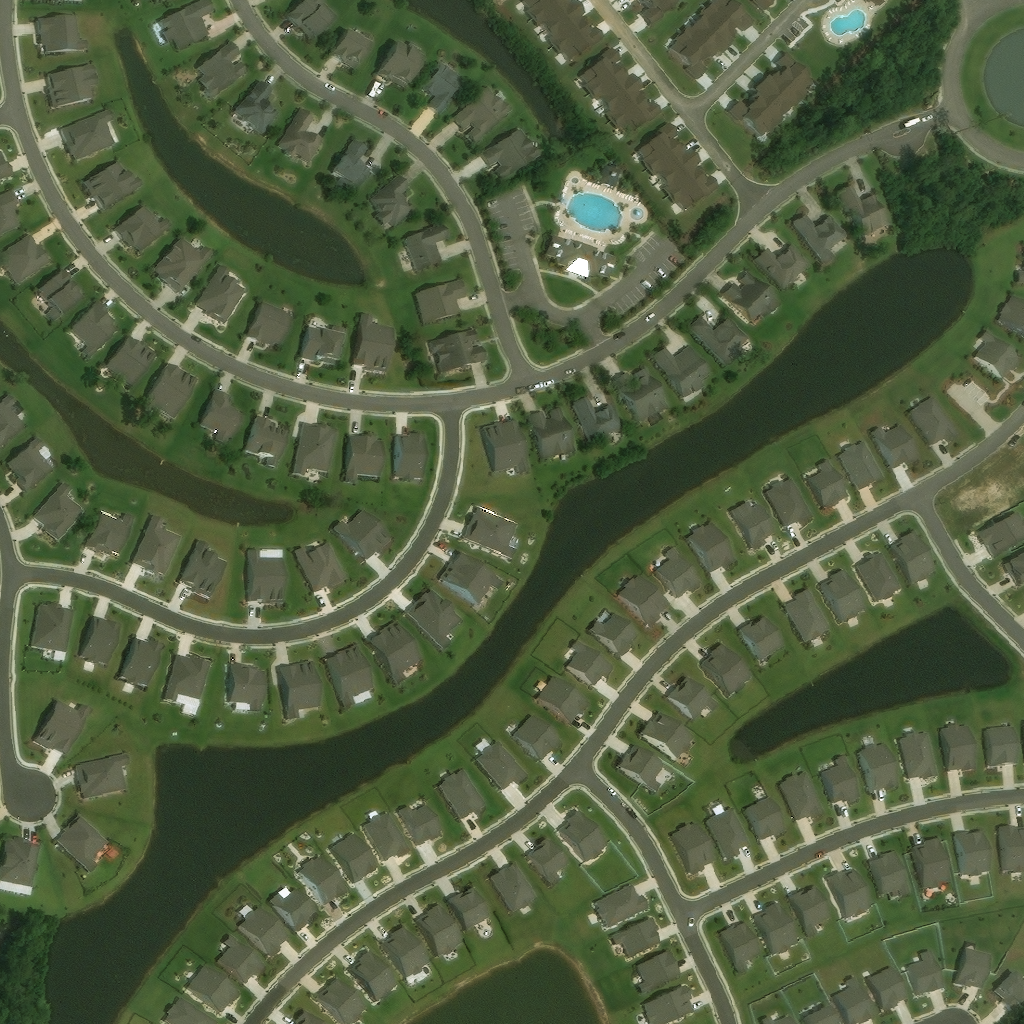

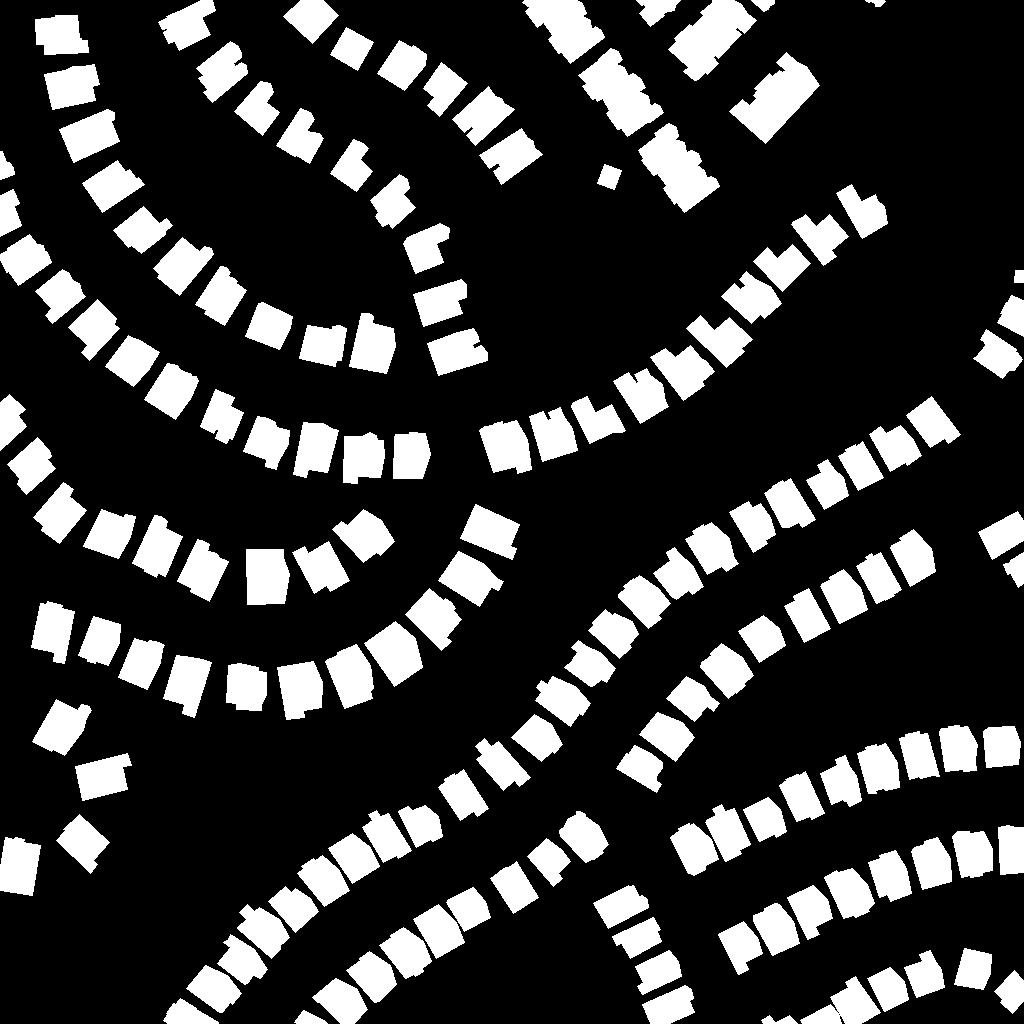

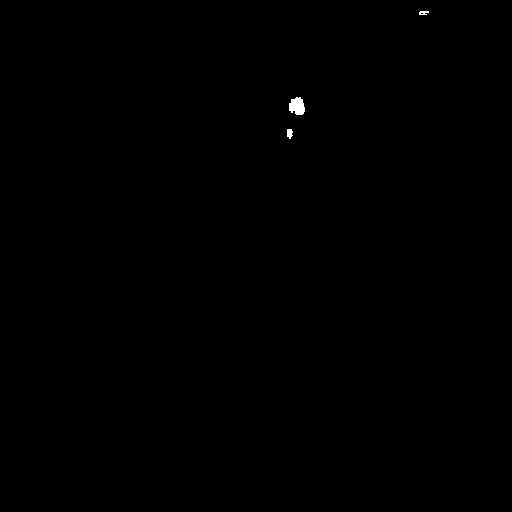

In [8]:
import PIL
from PIL import ImageOps
from IPython.display import Image, display

def display_mask(i):
  mask = np.argmax(test_preds[i], axis=-1)
  mask = np.expand_dims(mask, axis=-1)
  img = ImageOps.autocontrast(array_to_img(mask))
  display(img)

# 예측 결과 출력
i = 12

display(Image(filename=test_input_img_paths[i]))
img = ImageOps.autocontrast(load_img(test_target_img_paths[i]))
display(img)
display_mask(i)


# MIOU 평가 (xBD test Data)

In [9]:
y_true_arrays = [load_img(path, target_size=img_size, color_mode='grayscale') for path in test_target_img_paths]
y_true = np.array([np.expand_dims(np.array(img), axis=-1) for img in y_true_arrays])
y_true = y_true.squeeze() # 필요시 차원 축소
# 예측 레이블 준비

y_pred = np.argmax(test_preds, axis=-1)

# mIoU 계산
def mean_iou(y_true, y_pred, num_classes):
  intersection = np.zeros(num_classes)
  union = np.zeros(num_classes)
  for i in range(num_classes):
    intersection[i] = np.logical_and(y_true == i, y_pred == i).sum()
    union[i] = np.logical_or(y_true == i, y_pred == i).sum()
  iou = intersection / np.maximum(union, 1)
  mIoU = np.mean(iou)
  return mIoU

miou_score = mean_iou(y_true, y_pred, num_classes)
print("Mean IoU for the test set is:", miou_score)

Mean IoU for the test set is: 0.49442684654462843
